In [60]:
import pandas as pd 
import pickle
import seaborn as sns
import altair as alt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [10]:
# Data

df_melted_kmeans_data = pickle.load(open("../data/go_terms/df_melted_kmeans_data.p", "rb"))
df_melted_birch_data = pickle.load(open("../data/go_terms/df_melted_birch_data.p", "rb"))

df_all_merged_kmeans_data = pickle.load(open("../data/go_terms/df_all_merged_kmeans_data.p", "rb"))
df_all_merged_birch_data = pickle.load(open("../data/go_terms/df_all_merged_birch_data.p", "rb"))


In [11]:
condition_to_loci_file = "../data/new_sample2condition.txt"

# load mapping from sample to condition
with open(condition_to_loci_file,'r') as f:
    loci_to_ferm_run = str(f.readline()[1:(len(f.readline())-1)]).split(',')

    loci_tracker = dict(loci.replace('"', "").strip().split(':') for loci in loci_to_ferm_run)
    
conditions = list(set(map(str.strip, loci_tracker.values())))
conditions

['lowCu',
 'lowO2_slow_growth',
 'aa3_KO',
 'uMax',
 'slow_growth',
 'highCu',
 'highO2_slow_growth',
 'NoLanthanum',
 'crotonic_acid',
 'lowO2_fast_growth',
 'WT_control',
 'unknown',
 'medCu',
 'lowO2_low_iron_fast_growth',
 'MeOH',
 'WithLanthanum',
 'NoCu',
 'NO3_lowO2_slow_growth',
 'lowCH4',
 'LanzaTech']

# Parallel Coordinates Plot

In [13]:
def altair_pcoords(df,title,xorder='exp_condition_order'):
    # If more than 30 entries, make 2 columns
    col_num = 1 if len(df['locus_tag'].unique()) <=50 else 2
    
    highlight = alt.selection(type='single', on='mouseover',
                              fields=['desc_string'], nearest=True)
    
    selection = alt.selection_multi(fields=['desc_string'], bind='legend')


    base = alt.Chart(df.sort_values(xorder),
                     title=title
        ).encode(
        x=alt.X(f'{xorder}:N',
                sort=alt.EncodingSortField(field=f"{xorder}:N", op="count"),
                axis=alt.Axis(labelAngle=-45)
               ),
        y='mean:Q',
        color=alt.Color('desc_string:N',
                        legend=alt.Legend(title='Gene', 
                                          orient = 'right',
                                          labelLimit=0,
                                          columns=col_num,
                                          symbolLimit=200
                                         )),
        size=alt.value(100)        
    )
    

    lines = base.mark_line().encode(
        size=alt.condition((selection|highlight), alt.value(3), alt.value(1)),
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.5))
    ).add_selection(
        selection,
    ).properties(
         width=600,
         height=400
    ).interactive()
    
    
    points = base.mark_circle().encode(
        tooltip=['locus_tag','product','group','gene', 'go_terms',"start_coord", "end_coord", "length", "translation"],
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.2)),
        size=alt.condition((selection|highlight), alt.value(100), alt.value(3))
    ).add_selection(highlight)

    #return points + lines
    return lines + points

def check_cluster_expression(df, cols,cluster_id = 0,title = "cluster title", just_data = False):

    cols = list(conditions) 
    df['desc_string'] = df.apply(lambda row: f"{row['locus_tag']}|{row['gene']}|{row['product']}",axis=1)
    id_vars = ['locus_tag','desc_string','cluster_id', "gene", "product", "start_coord", "end_coord", "length", "translation", "group", "go_terms"]
    dfm = df.melt(id_vars=id_vars, value_vars=cols,var_name='exp_condition',value_name="mean")

    dfm
    # altair sort helper
    list_ordering = conditions
    dfm["exp_condition_order"] = pd.Categorical(dfm["exp_condition"], categories=list_ordering)
    
    if just_data: 
        return dfm
    else: 
        return altair_pcoords(dfm[dfm['cluster_id']==cluster_id],title)

In [14]:
check_cluster_expression(
    df_all_merged_kmeans_data, 
    conditions,
    8,
    "kmeans, cluster 8", 
    just_data= False)

alt.LayerChart(...)

# MDS - tSNE Cluster Plot

In [42]:
df_avg_log_ratio_scaled_tpm = pd.read_csv("../data/avg_log_ratio_scaled.csv")
df_avg_log_ratio_scaled_tpm = df_avg_log_ratio_scaled_tpm.set_index(df_avg_log_ratio_scaled_tpm['locus_tag'])

df_avg_log_ratio_scaled_tpm = df_avg_log_ratio_scaled_tpm.drop(['locus_tag'], axis = 1)
df_avg_log_ratio_scaled_tpm

,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.515808,-0.012058,-0.480048,-0.163349,-0.648447,-0.037469,-0.491013,-0.410117,-0.485123,0.085206,0.060397,-0.186470,-0.136377,-0.203679,-0.487435,-0.243069,0.044174,-0.122244,0.185208,-0.620522
EQU24_RS00010,0.480568,-0.659004,-0.218643,0.075821,-0.485571,-0.114821,-0.462526,0.094641,-0.209870,0.873114,0.504025,-0.305931,0.204399,-0.103679,-0.283817,0.062219,0.461263,0.103303,0.191813,-0.798028
EQU24_RS00015,-1.072637,0.327816,-0.461533,-0.212764,-0.583017,-0.648530,-0.633792,-0.917224,-0.048206,0.220238,0.138747,-0.385615,-0.106453,0.142845,-0.057250,-0.235794,0.034638,-0.609406,0.158782,-0.753895
EQU24_RS00020,0.723618,-1.032390,0.072132,-0.253222,-0.352283,0.183488,-0.292974,0.144541,0.167185,0.346152,-0.108216,-0.132304,-0.051795,-0.311922,0.060748,-0.078771,0.169326,0.274118,0.198566,-0.532597
EQU24_RS00025,0.424262,-0.479325,0.028098,0.116538,-0.261659,0.082847,-0.454102,-0.051229,0.045575,0.265104,0.450111,0.011533,0.240761,-0.573878,0.722346,0.029248,0.311967,0.268652,0.181731,-0.011128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.445389,-0.627550,-1.170665,-0.396450,-1.877416,-0.819438,-1.715711,-0.966683,-0.144739,0.277257,-1.123350,0.097626,-0.295041,0.153868,0.071796,-0.825055,0.213758,-1.168263,0.206290,-0.784262
EQU24_RS22140,0.309593,-1.327737,-1.065740,-0.706776,-1.812366,-0.818297,-1.749368,-0.654022,-0.239402,-0.195778,-1.305006,-0.407547,-0.418638,0.243782,-0.820586,-0.906017,-0.091223,-0.946392,0.229381,-1.159766
EQU24_RS22145,-1.028264,-0.395724,-1.265702,-0.657315,-2.492508,-0.803695,-2.140667,-0.926349,-0.555916,-0.028408,-1.210127,0.079368,-0.380479,0.362696,-0.218650,-0.747930,0.020182,-0.861652,0.229635,-1.151259


In [49]:
# cluster labels
df_ideal_labels = pickle.load(open("../data/ideal_labels", "rb"))
df_ideal_labels

,method,labels,param1,param2,param3
0,agglomerative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",single,19.0,NaN
1,agglomerative,"[7, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 8, 7, 8, 7, ...",complete,19.0,NaN
2,agglomerative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",single,12.0,NaN
3,agglomerative,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",average,21.0,NaN
4,kmeans,"[12, 4, 17, 4, 4, 1, 12, 7, 7, 7, 7, 12, 17, 9...",19,NaN,NaN
5,kmeans,"[18, 18, 17, 18, 18, 0, 5, 0, 0, 0, 0, 5, 3, 1...",20,NaN,NaN
6,birch,"[0, 6, 0, 6, 6, 14, 6, 14, 14, 14, 14, 6, 12, ...",0.48,54.0,16.0
7,birch,"[14, 14, 3, 14, 21, 5, 5, 21, 21, 21, 21, 5, 7...",0.48,50.0,31.0
8,kmedoids,"[25, 9, 20, 26, 9, 19, 18, 19, 19, 21, 21, 22,...",36,NaN,NaN
9,dbscan,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.5,4.0,NaN


In [53]:
kmeans_19_labels = df_ideal_labels.iloc[4]['labels']
kmeans_19_labels

array([12,  4, 17, ...,  0,  0,  0], dtype=int32)

In [44]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_avg_log_ratio_scaled_tpm) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4213 samples in 0.019s...
[t-SNE] Computed neighbors for 4213 samples in 1.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4213
[t-SNE] Computed conditional probabilities for sample 2000 / 4213
[t-SNE] Computed conditional probabilities for sample 3000 / 4213
[t-SNE] Computed conditional probabilities for sample 4000 / 4213
[t-SNE] Computed conditional probabilities for sample 4213 / 4213
[t-SNE] Mean sigma: 0.560552
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.138840
[t-SNE] KL divergence after 1000 iterations: 1.780383


In [55]:
df_tsne_plot = pd.DataFrame()
df_tsne_plot["y"] = kmeans_19_labels
df_tsne_plot["comp-1"] = z[:,0]
df_tsne_plot["comp-2"] = z[:,1]

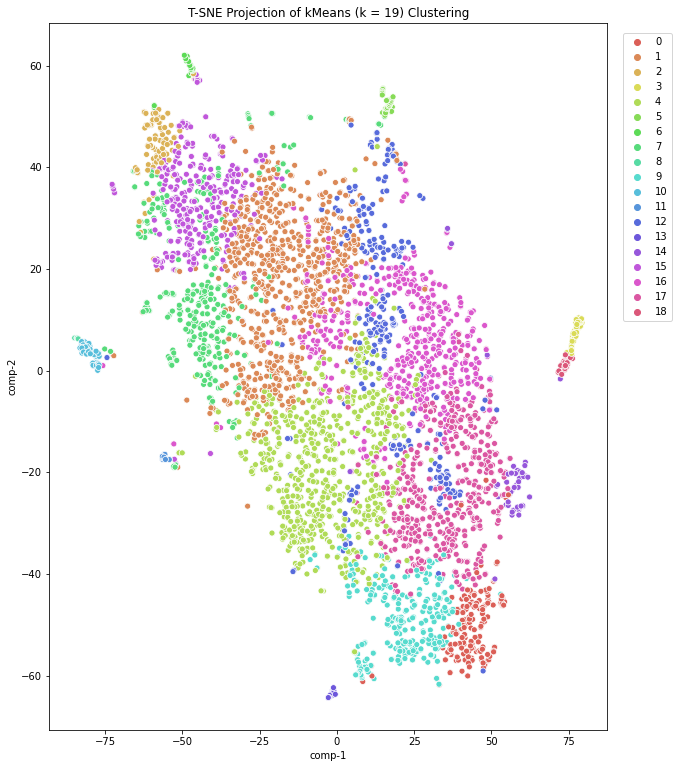

In [83]:

plt.figure(figsize=(10, 13))

ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne_plot.y.tolist(),
                palette=sns.color_palette("hls", 19),
                data=df).set(title="T-SNE Projection of kMeans (k = 19) Clustering") 

plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=1)

In [ ]:
        freqs = df_dim_reduced_scaled['label'].unique()
        colors = sns.color_palette('Set2', n_colors=len(freqs))  # get a number of colors
        cmap = dict(zip(freqs, colors))  # zip freqs to colors and create a dict

        ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], hue = df_dim_reduced_scaled['label'], legend='full', palette=cmap)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel("PC 1", fontsize = 15)
        ax.set_ylabel("PC 2", fontsize = 15)
        ax.set_title(title, fontsize = 20)

        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        plt.show()
    